# Kaggle Competition: M5 Forecasting
## Estimate the unit sales of Walmart retail goods

- Time Series Analysis

- Author: Rodrigo de Lima Oliveira

- References:

     - [DSA] https://www.datascienceacademy.com.br/
     - [MLCOURSER.AI] https://mlcourse.ai/
     - [KAGGLE] https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

# # Part 1. Loading the libraries

In [18]:
# Importing libraries that will be used in this project
import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
from dateutil.relativedelta import relativedelta
import time
import gc
import os
from tqdm import tqdm_notebook

# Ignore warnings
import warnings
warnings.filterwarnings (action = "ignore")

# Set some options in Jupyter to display datasets
pd.set_option ('display.max_columns', 200)
pd.set_option ('display.max_rows', 200)

# Variable to control Kaggle training
TRAIN_OFFLINE = True

# Variable to indicate the local path
LOCAL_DATA_FOLDER  = 'm5-forecasting-accuracy/'
KAGGLE_DATA_FOLDER = '/m5-forecasting-accuracy/'

In [19]:
# Importing sklearn libraries
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# lib of machine learning templates
#import xgboost as xgb
#import lightgbm as lgb

# Part 2. Importing the data

In [20]:
# Function for reducing the used memory
def reduce_mem_usage (df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage (). sum () / 1024 ** 2
    for col in df.columns:
        col_type = df [col] .dtypes
        if col_type in numerics:
            c_min = df [col] .min ()
            c_max = df [col] .max ()
            if str (col_type) [: 3] == 'int':
                if c_min> np.iinfo (np.int8) .min and c_max <np.iinfo (np.int8) .max:
                    df [col] = df [col] .astype (np.int8)
                elif c_min> np.iinfo (np.int16) .min and c_max <np.iinfo (np.int16) .max:
                    df [col] = df [col] .astype (np.int16)
                elif c_min> np.iinfo (np.int32) .min and c_max <np.iinfo (np.int32) .max:
                    df [col] = df [col] .astype (np.int32)
                elif c_min> np.iinfo (np.int64) .min and c_max <np.iinfo (np.int64) .max:
                    df [col] = df [col] .astype (np.int64)
            else:
                if c_min> np.finfo (np.float16) .min and c_max <np.finfo (np.float16) .max:
                    df [col] = df [col] .astype (np.float16)
                elif c_min> np.finfo (np.float32) .min and c_max <np.finfo (np.float32) .max:
                    df [col] = df [col] .astype (np.float32)
                else:
                    df [col] = df [col] .astype (np.float64)
    end_mem = df.memory_usage (). sum () / 1024 ** 2
    if verbose: print ('Mem. usage decreased to {: 5.2f} Mb ({: .1f}% reduction)'. format (end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Function for reading LOCAL or KAGGLE files
def read_data ():
    
    # If local
    if TRAIN_OFFLINE:

        calendar = pd.read_csv (os.path.join (LOCAL_DATA_FOLDER, 'calendar.csv'))
        sell_prices = pd.read_csv (os.path.join (LOCAL_DATA_FOLDER, 'sell_prices.csv'))
        sales_train_validation = pd.read_csv (os.path.join (LOCAL_DATA_FOLDER, 'sales_train_validation.csv'))
        submission = pd.read_csv (os.path.join (LOCAL_DATA_FOLDER, 'sample_submission.csv'))

    # If you are in the Kaggle environment
    else:
        
        calendar = pd.read_csv (os.path.join (KAGGLE_DATA_FOLDER, 'calendar.csv'))
        sell_prices = pd.read_csv (os.path.join (KAGGLE_DATA_FOLDER, 'sell_prices.csv'))
        sales_train_validation = pd.read_csv (os.path.join (KAGGLE_DATA_FOLDER, 'sales_train_validation.csv'))
        submission = pd.read_csv (os.path.join (KAGGLE_DATA_FOLDER, 'sample_submission.csv'))

    calendar = reduce_mem_usage (calendar)
    sell_prices = reduce_mem_usage (sell_prices)
    sales_train_validation = reduce_mem_usage (sales_train_validation)
    submission = reduce_mem_usage (submission)
        
    return calendar, sell_prices, sales_train_validation, submission

In [21]:
# Reading the data and applying memory reduction
calendar, sell_prices, sales_train_validation, submission = read_data ()

Mem. usage decreased to  0.12 Mb ( 41.9% reduction)
Mem. usage decreased to  130.48 Mb ( 37.5% reduction)
Mem. usage decreased to  95.00 Mb ( 78.7% reduction)
Mem. usage decreased to  2.09 Mb ( 84.5% reduction)


# Part 3. Feature Engineering

In [22]:
# Function to merge datasets returning only one dataframe
def reshape_and_merge (calendar, sell_prices, sales_train_validation, submission, nrows = 30000000, merge = False):
    
    # reshaping sales data using melt
    sales_train_validation = pd.melt (sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print ('Melted sales train validation has {} rows and {} columns'.format (sales_train_validation.shape [0], sales_train_validation.shape [1]))
    sales_trian_validation = reduce_mem_usage (sales_train_validation)
    
    # preparing test and validation records
    test_rows = [row for row in submission ['id'] if 'validation' in row]
    val_rows = [row for row in submission ['id'] if 'evaluation' in row]
    
    test = submission [submission ['id']. isin (test_rows)]
    val = submission [submission ['id']. isin (val_rows)]
    
    # renaming the columns
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921',
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930',
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949',
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958',
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967',
                   'd_1968', 'd_1969']
    
    # getting only product data and removing duplicate records
    product = sales_train_validation [['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]. drop_duplicates ()
    
    # merge with the product table
    test = test.merge (product, how = 'left', on = 'id')
    val = val.merge (product, how = 'left', on = 'id')
    
    # reshaping test and validation data
    test = pd.melt (test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt (val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # creating a new column to define training, test and validation data
    sales_train_validation ['part'] = 'train'
    test ['part'] = 'test'
    val ['part'] = 'val'
    
    # creating a single dataset with the addition of all training, validation and test records
    data = pd.concat ([sales_train_validation, test, val], axis = 0)
    
    # removing previous datasets
    del sales_train_validation, test, val
    
    # selecting only a few records for training
    data = data.loc [nrows:]
    
    # removing validation data
    data = data [data ['part']!= 'val']
    
    # performing the merge with calendar and price
    if merge:
        data = pd.merge (data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop (['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge (sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print ('Final dataset for training has {} rows and {} columns'.format (data.shape [0], data.shape [1]))
    else:
        pass
    
    return data

# Function for handling missing values ​​transformation of categorical and numeric features
def transform (data):
    
    # performing treatment on missing values ​​in categorical features
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data [feature] .fillna ('unknown', inplace = True)
    
    # performing treatment on missing values ​​in the sell_price feature
    data ['sell_price']. fillna (0, inplace = True)
        
    # turning features categories into numbers to make predictions
    encoder = preprocessing.LabelEncoder ()
    data ['id_encode'] = encoder.fit_transform (data ['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder ()
        data [feature] = encoder.fit_transform (data [feature])
    
    return data

In [23]:
%%time

# Reshaping and merging datasets
data = reshape_and_merge (calendar, sell_prices, sales_train_validation, submission, merge = True)

# Calling up the data transformation functions
data = transform (data)

# Viewing the final dataset header
data.head ()

# Clearing data from memory
gc.collect ()

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to  3226.27 Mb ( 0.0% reduction)
Final dataset for training has 29181090 rows and 21 columns
CPU times: user 2min 24s, sys: 1min 30s, total: 3min 54s
Wall time: 4min 33s


20

In [24]:
# Checking the start and end date of the dataset
print(min(data['date']), max(data['date']))

2013-10-08 2016-05-22


# Part 4. Time Series em Python

Part 4. Time Series in Python
Let's take a look at how to work with time series using this Kaggle competition. So let's analyze:

     Methods and models that we can use for predictions in this dataset
     Apply double and triple exponential smoothing
     Analyze stationarity
     Create SARIMA model
     Make predictions using xgboost and lightgbm

In [33]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
0,HOUSEHOLD_1_331_WI_3_validation,2326,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,4.878906,23269
1,HOUSEHOLD_1_332_WI_3_validation,2327,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,0.000000,23279
2,HOUSEHOLD_1_333_WI_3_validation,2328,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,2.970703,23289
3,HOUSEHOLD_1_334_WI_3_validation,2329,5,2,9,2,11,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,0.979980,23299
4,HOUSEHOLD_1_335_WI_3_validation,2330,5,2,9,2,0,train,2013-10-08,11337,4,10,2013,30,4,2,2,1,0,1,8.968750,23309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29181085,FOODS_3_823_WI_3_validation,1432,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,2.980469,14329
29181086,FOODS_3_824_WI_3_validation,1433,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,2.480469,14339
29181087,FOODS_3_825_WI_3_validation,1434,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,3.980469,14349
29181088,FOODS_3_826_WI_3_validation,1435,2,0,9,2,0,test,2016-05-22,11617,2,5,2016,30,4,2,2,0,0,0,1.280273,14359


In [125]:
data[data['id'] == 'FOODS_3_634_WI_2_validation'].head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
29410,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-09,11337,5,10,2013,30,4,2,2,1,1,1,3.980469,12468
59900,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2013-10-10,11337,6,10,2013,30,4,2,2,1,0,0,3.980469,12468
90390,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-11,11337,7,10,2013,30,4,2,2,0,1,1,3.980469,12468
120880,FOODS_3_634_WI_2_validation,1246,2,0,8,2,13,train,2013-10-12,11338,1,10,2013,30,4,2,2,0,1,1,3.980469,12468
151370,FOODS_3_634_WI_2_validation,1246,2,0,8,2,10,train,2013-10-13,11338,2,10,2013,30,4,2,2,0,1,0,3.980469,12468


In [126]:
data[(data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['part'] == 'train')]

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
29410,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-09,11337,5,10,2013,30,4,2,2,1,1,1,3.980469,12468
59900,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2013-10-10,11337,6,10,2013,30,4,2,2,1,0,0,3.980469,12468
90390,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,2013-10-11,11337,7,10,2013,30,4,2,2,0,1,1,3.980469,12468
120880,FOODS_3_634_WI_2_validation,1246,2,0,8,2,13,train,2013-10-12,11338,1,10,2013,30,4,2,2,0,1,1,3.980469,12468
151370,FOODS_3_634_WI_2_validation,1246,2,0,8,2,10,train,2013-10-13,11338,2,10,2013,30,4,2,2,0,1,0,3.980469,12468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28202170,FOODS_3_634_WI_2_validation,1246,2,0,8,2,2,train,2016-04-20,11612,5,4,2016,30,4,2,2,0,0,0,3.980469,12468
28232660,FOODS_3_634_WI_2_validation,1246,2,0,8,2,3,train,2016-04-21,11612,6,4,2016,30,4,2,2,0,0,0,3.980469,12468
28263150,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2016-04-22,11612,7,4,2016,30,4,2,2,0,0,0,3.980469,12468
28293640,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,2016-04-23,11613,1,4,2016,30,4,2,2,0,0,0,3.980469,12468


In [127]:
# Select training and validation data only for analysis
# Selecting only 1 item for testing: FOODS_3_634_WI_2
df = data [(data['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand']> 0) & (data [ 'demand'] <= 15)]

# Selecting only a few columns for analysis and training
df = df [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]

# Transforming the date as index
df = df.set_index ('date')

# Viewing the dataset result
df.head ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2013-10-09,8,2,0,8,2,30,4,1,3.980469
2013-10-10,5,2,0,8,2,30,4,0,3.980469
2013-10-11,8,2,0,8,2,30,4,1,3.980469
2013-10-12,13,2,0,8,2,30,4,1,3.980469
2013-10-13,10,2,0,8,2,30,4,0,3.980469


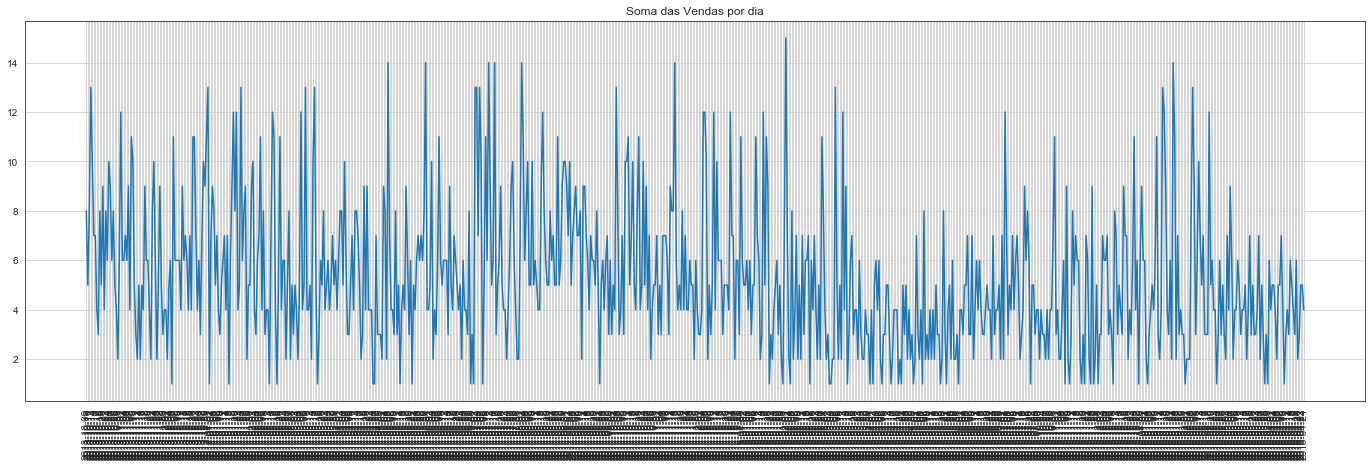

In [128]:
plt.figure(figsize=(24, 7))
plt.plot(df['demand'])
plt.title('Soma das Vendas por dia')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [129]:
# Viewing distribution information for the variable "demand"
sns.set_style ("white")
sns.set_color_codes (palette = 'deep')
f, ax = plt.subplots (figsize = (12, 8))

# Fit a normal distribution
mu, std = norm.fit (df ['demand'])

# Checking the frequency distribution of the variable "demand"
sns.distplot (df ['demand'], color = "b", fit = stats.norm)
ax.xaxis.grid (False)
ax.set (ylabel = "Frequency")
ax.set (xlabel = "Demand")
ax.set (title = "Demand distribution: mu =% .2f, std =% .2f"% (mu, std))
sns.despine (trim = True, left = True)

# Adding Skewness and Kurtosis
ax.text (x = 1.1, y = 1, transform = ax.transAxes, s = "Skewness:% f"% df ['demand']. skew (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'xkcd: poo brown')
ax.text (x = 1.1, y = 0.95, transform = ax.transAxes, s = "Kurtosis:% f"% df ['demand']. kurt (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'xkcd: dried blood')

plt.show ()

ValueError: Invalid RGBA argument: 'xkcd: poo brown'

<Figure size 864x576 with 1 Axes>

4.1. Metrics for forecasting

     Before starting to make forecasts, let's understand how to measure the performance of our forecasts and take a look at the metric that will be used.

     Mean Absolute Error: this is an interpretable metric because it has the same unit of measure as the initial series, [0, + ∞) [0, + ∞)

MAE = ∑i = 1n | yi − ŷ i | nMAE = ∑i = 1n | yi − y ^ i | n

sklearn.metrics.mean_absolute_error

     Mean Absolute Percentage Error: it is the same as the MAE, but it is calculated as a percentage, which is very convenient when you want to explain the quality of the model, [0, + ∞) [0, + ∞)

MAPE = 100n∑i = 1n | yi − ŷ i | yi

In [130]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 4.2. Move, smooth, evaluate

Let's start with a hypothesis: "tomorrow will be the same as today". However, using a model like $ \ hat {y} _ {t} = y_ {t-1} $, we will assume that the future value of our variable depends on the average of the previous values of $ k $. Therefore, we will use the ** moving average **.


$ \ hat {y} _ {t} = \ frac {1} {k} \ displaystyle \ sum ^ {k} _ {n = 1} y_ {t-n} $

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

#  realizando as previsões dos últimos 28 dias
moving_average(df, 28)

Unfortunately, we cannot make predictions for the future - to get the next value, we need the previous values to be actually observed. But the moving average has another use - to smooth the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling (window) .mean ()`] (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The larger the window, the smoother the trend. In the case of very noisy data, usually found in finance or stock market data, this procedure can help detect common patterns.

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
# Let's smooth out using a 7-day window
plotMovingAverage (df ['demand'], 7)

In [ ]:
# Let's smooth out using a 28-day window
plotMovingAverage (df ['demand'], 28)

When we apply data smoothing, we can clearly see the sales dynamics in the period.

We can also plot confidence intervals.

In [ ]:
plotMovingAverage(df['demand'], 28, plot_intervals=True)

** Weighted average ** is a simple modification of the moving average. Weights add up to `1` with higher weights attributed to more recent observations.


$ \ hat {y} _ {t} = \ displaystyle \ sum ^ {k} _ {n = 1} \ omega_n y_ {t + 1-n} $

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(df['demand'], [0.6, 0.3, 0.1])

## 4.3 Exponential smoothing

Now, let's see what happens if, instead of pondering the last $ k $ values ​​of the time series, we start pondering all available observations while decreasing the weights exponentially as we go further in time. There is a formula for this ** [exponential smoothing (https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this formula:

$$ \ hat {y} _ {t} = \ alpha \ cdot y_t + (1- \ alpha) \ cdot \ hat y_ {t-1} $$


Here, the model value is a weighted average between the current true value and the model's previous values. The weight $ \ alpha $ is called the smoothing factor. It defines how quickly we "forget" the last true observation. The lower $ \ alpha $, the greater the influence of previous observations and the smoother the series will be.

Exponentiality is hidden in the recursion of the function - we multiply by $ (1- \ alpha) $ with each pass, which already contains a multiplication by $ (1- \ alpha) $ of the model's previous values.

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [ ]:
plotExponentialSmoothing(df['demand'], [0.3, 0.05])

## 4.4 Double exponential smoothing

So far, the methods presented have been for a single forecast of a future point (with good smoothing). This is cool, but it is also not enough. We are going to extend exponential smoothing so that we can predict two future points (and of course, we will also include more smoothing).

Serial decomposition will help us obtain two components: intercept (level) $ \ ell $ and slope (trend) $ b $. We learned to predict intercept (or expected value of the series) with our previous methods; we will now apply the same exponential smoothing to the trend, assuming that the future direction of changes in the time series depends on previous weighted changes. As a result, we obtain the following set of functions:

$$ \ ell_x = \ alpha y_x + (1- \ alpha) (\ ell_ {x-1} + b_ {x-1}) $$

$$ b_x = \ beta (\ ell_x - \ ell_ {x-1}) + (1- \ beta) b_ {x-1} $$

$$ \ hat {y} _ {x + 1} = \ ell_x + b_x $$


The first describes the intercept, which depends on the current value of the series. The second term is now divided into previous level and trend values. The second function describes the trend, which depends on the level changes in the current stage and the previous value of the trend. In this case, the $ \ beta $ coefficient is a weight for exponential smoothing. The final forecast is the sum of the values ​​of the intercept model and the trend.

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [ ]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [ ]:
plotDoubleExponentialSmoothing(df['demand'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now we have to adjust two parameters: $ \ alpha $ and $ \ beta $. The first is responsible for smoothing the series around the trend, the second for smoothing the trend itself. The higher the values, the greater the weight of the most recent observations and the less smoothed the series will be.

## 4.5 Triple exponential smoothing a.k.a. Holt-Winters

We saw exponential smoothing and double exponential smoothing. This time, we are going to go into triple exponential smoothing.


The idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. The seasonal components of the model explain repeated variations around the intercept and trend and will be specified by the duration of the season, that is, by the period after which the variations are repeated. For each observation of the period, there is a separate component; for example, if the period is 28 days (a monthly seasonality), we will have 28 seasonal components, one for each day of the month.

With that, let's write a new system of equations:

$$ \ ell_x = \ alpha (y_x - s_ {x-L}) + (1- \ alpha) (\ ell_ {x-1} + b_ {x-1}) $$

$$ b_x = \ beta (\ ell_x - \ ell_ {x-1}) + (1- \ beta) b_ {x-1} $$

$$ s_x = \ gamma (y_x - \ ell_x) + (1- \ gamma) s_ {x-L} $$

$$ \ hat {y} _ {x + m} = \ ell_x + mb_x + s_ {x-L + 1 + (m-1) modL} $$


The intercept now depends on the current value of the series minus any corresponding seasonal component. The trend remains unchanged and the seasonal component depends on the current value of the series minus the intercept and the previous value of the component. Take into account that the component is smoothed over all available periods; for example, if we have a Monday component, only the average of other Mondays will be calculated. You can read more about how the average works and how the initial trend and seasonal components are approximated [here] (http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm) . Now that we have the seasonal component, we can predict not just a step or two ahead, but also an arbitrary $ m $ future, which is very good.

Below is the code for a triple exponential smoothing model, also known by the surnames of its creators, Charles Holt and his student Peter Winters. In addition, the Brutlag method was included in the model to produce confidence intervals:


$$ \ hat y_ {max_x} = \ ell_ {x − 1} + b_ {x − 1} + s_ {x − T} + m⋅d_ {t − T} $$

$$ \ hat y_ {min_x} = \ ell_ {x − 1} + b_ {x − 1} + s_ {x − T} -m⋅d_ {t − T} $$

$$ d_t = \ gamma∣y_t− \ hat y_t∣ + (1− \ gamma) d_ {t − T}, $$

where $ T $ is the length of the period, $ d $ is the predicted deviation. Other parameters were obtained from the triple exponential smoothing. You can read more about the method and its applicability to the detection of anomalies in time series [here] (http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [131]:
class HoltWinters:
    
    '''
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    '''
    
    
    def __init__ (self, series, slen, alpha, beta, gamma, n_preds, scaling_factor = 1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend (self):
        sum = 0.0
        for i in range (self.slen):
            sum += float (self.series [i + self.slen] - self.series [i]) / self.slen
        return sum / self.slen
    
    def initial_seasonal_components (self):
        seasonals = {}
        season_averages = []
        n_seasons = int (len (self.series) /self.slen)
        # let's calculate season averages
        for j in range (n_seasons):
            season_averages.append (sum (self.series [self.slen * j: self.slen * j + self.slen]) / float (self.slen))
        # let's calculate initial values
        for i in range (self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range (n_seasons):
                sum_of_vals_over_avg += self.series [self.slen * j + i] -season_averages [j]
            seasonals [i] = sum_of_vals_over_avg / n_seasons
        return seasonals

          
    def triple_exponential_smoothing (self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components ()
        
        for i in range (len (self.series) + self.n_preds):
            if i == 0: # components initialization
                smooth = self.series [0]
                trend = self.initial_trend ()
                self.result.append (self.series [0])
                self.Smooth.append (smooth)
                self.Trend.append (trend)
                self.Season.append (seasonals [i% self.slen])
                
                self.PredictedDeviation.append (0)
                
                self.UpperBond.append (self.result [0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation [0])
                
                self.LowerBond.append (self.result [0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation [0])
                continue
                
            if i>= len (self.series): # predicting
                m = i - len (self.series) + 1
                self.result.append ((smooth + m * trend) + seasonals [i% self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append (self.PredictedDeviation [-1] * 1.01)
                
            else:
                val = self.series [i]
                last_smooth, smooth = smooth, self.alpha * (val-seasonals [i% self.slen]) + (1-self.alpha) * (smooth + trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta) * trend
                seasonals [i% self.slen] = self.gamma * (val-smooth) + (1-self.gamma) * seasonals [i% self.slen]
                self.result.append (smooth + trend + seasonals [i% self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append (self.gamma * np.abs (self.series [i] - self.result [i])
                                               + (1-self.gamma) * self.PredictedDeviation [-1])
                     
            self.UpperBond.append (self.result [-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation [-1])

            self.LowerBond.append (self.result [-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation [-1])

            self.Smooth.append (smooth)
            self.Trend.append (trend)
            self.Season.append (seasonals [i% self.slen])

## 4.6 Time series cross validation

Before starting to build a model, let's check how to estimate the model parameters automatically.

There is nothing unusual here; as always, we have to choose a loss function suitable for the task that will tell us how close the model approaches the data. Then, using cross-validation, we will evaluate our chosen loss function for the model parameters provided, calculate the gradient, adjust the model parameters, and so on, eventually dropping to the global minimum.

You may be wondering how to cross-validate time series because time series have this time structure and you cannot mix values ​​randomly without preserving that structure. With randomization, all time dependencies between observations will be lost. That's why we will have to use a more complicated approach to optimize the model's parameters. I don't know if there is an official name for this, but at [CrossValidated] (https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection) , you can find some answers to this method which is "cross-validation on an ongoing basis".

The idea is quite simple - we trained our model on a small segment of the time series from the beginning to tt, made predictions for the next steps of t + nt + n and calculated an error. Next, we expand our training sample to the value t + nt + n, make predictions from t + nt + n to t + 2 ∗ nt + 2 ∗ n and continue moving the time series test window until we reach the last available observation. As a result, we have many samples nn between the initial training sample and the last observation.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Now, knowing how to set up cross validation, we can find the ideal parameters for the Holt-Winters model. Remember that we have daily seasonality, hence the parameter slen = 1.

In [132]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=28):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], 
                            slen=slen, 
                            alpha=alpha, 
                            beta=beta, 
                            gamma=gamma, 
                            n_preds=len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [133]:
%%time

new_data = df['demand']

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, 
               x0=x, 
               args=(new_data, mean_squared_error), 
               method="TNC", 
               bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 28 days
model = HoltWinters(new_data, 
                    slen = 28, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 28, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.005976951099115446 0.017117308114189933 0.06855978202599727
CPU times: user 7 s, sys: 24.7 ms, total: 7.02 s
Wall time: 7.05 s


In [134]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    
    #error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    error = rmse(series.values, model.result[:len(series)])
    plt.title("RMSE: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-60, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

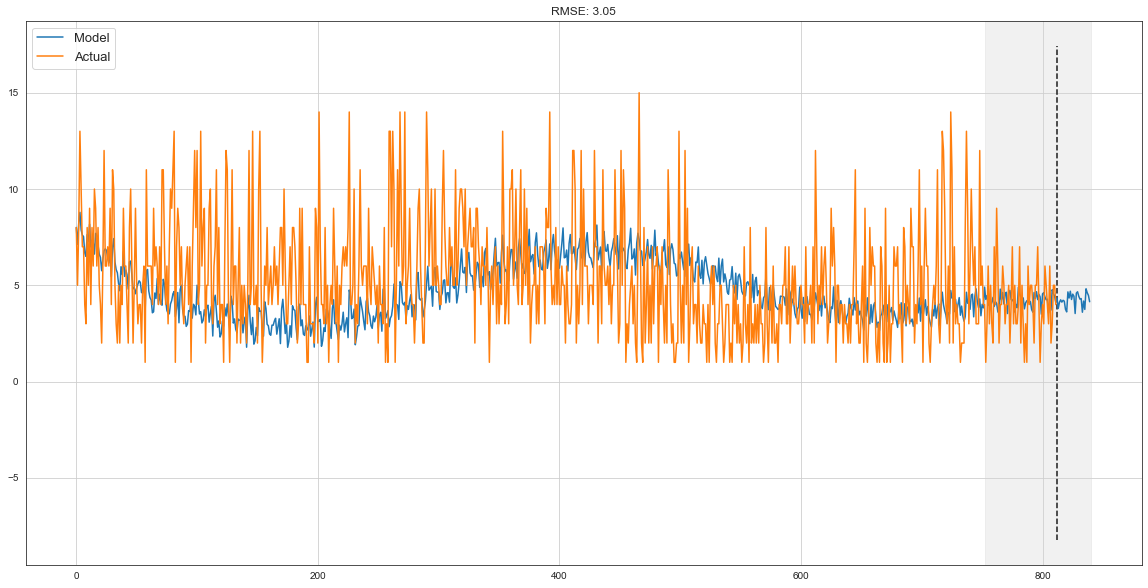

In [135]:
plotHoltWinters(df['demand'])

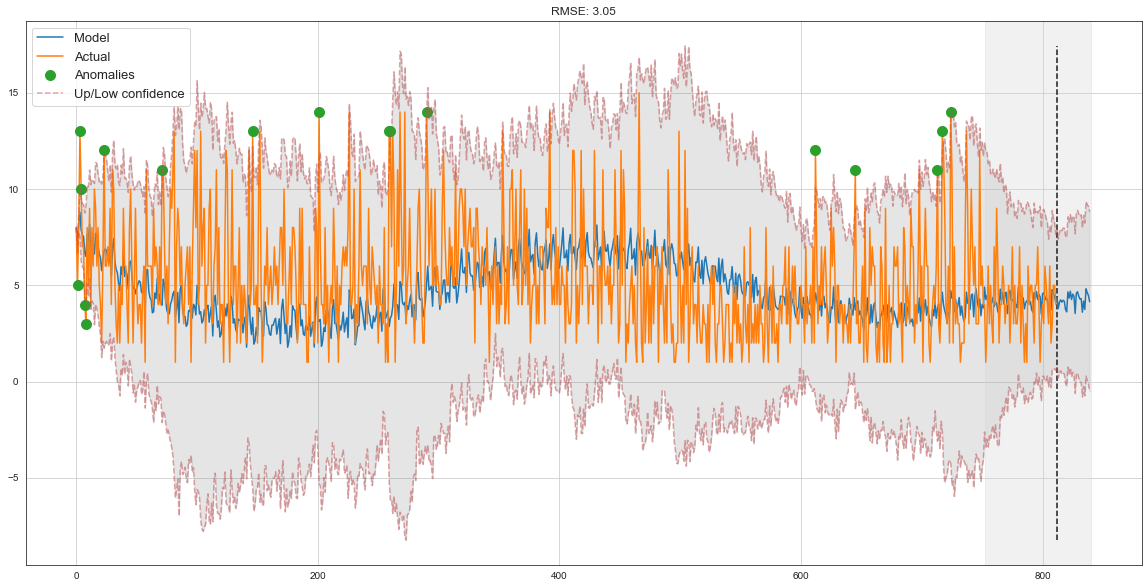

In [136]:
plotHoltWinters(df['demand'], plot_intervals=True, plot_anomalies=True)

Judging by the graphs, our model successfully approximated the initial time series, capturing daily seasonality, the general downward trend and even some anomalies. If you look at the deviations from the model, you can clearly see that the model reacts a lot to changes in the series structure, but then quickly returns the deviation to normal values, essentially "forgetting" the past. This model feature allows us to quickly create anomaly detection systems, even for noise in the series data, without spending a lot of time preparing the data and training the model.

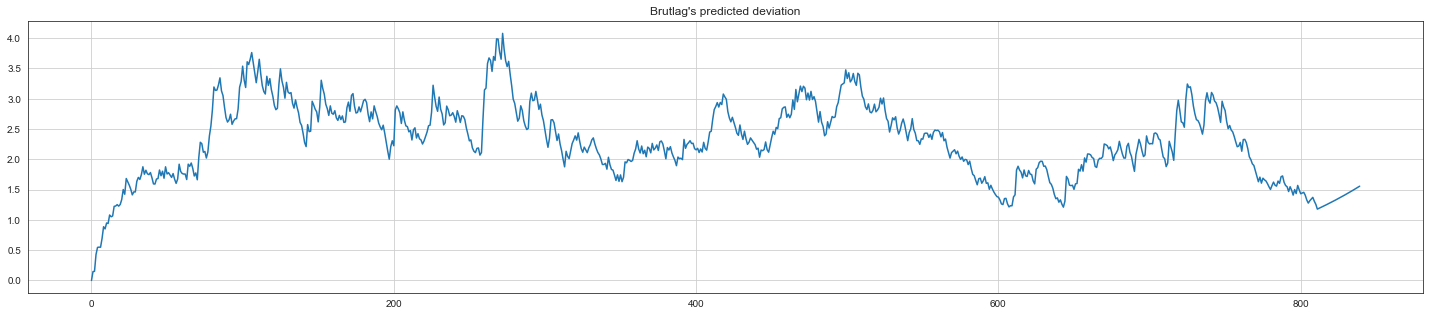

In [137]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## 4.7 Abordagem Econometrica

### Stationarity


Before starting, I must mention an important property of the time series: [** stationarity **] (https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, it means that it does not change its statistical properties over time, that is, its mean and variance. (The constancy of the variation is called [homoscedasticity] (https://en.wikipedia.org/wiki/Homoscedasticity)) The covariance function does not depend on time, it must depend only on the distance between observations. You can see these images from [Sean Abu] 's post (http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- The red graph below is not stationary because the average increases over time.

<img src = "https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png" />

- Observing the variation of values ​​over time

<img src = "https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png" />

- Finally, the covariance of the i term and the (i + m) term must not be a function of time. In the chart below, you will notice that the spread approaches as time increases. Therefore, the covariance is not constant as in the graph on the right.


<img src = "https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png" />

So why is stationarity so important? Because it is easy to make predictions in a stationary series, as we can assume that future statistical properties will not be different from those currently observed. Most time series models, in one way or another, try to predict these properties (mean or variation, for example). Future predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are not stationary, but we can (and should) change that.

So, let's see how to detect non-stationarity. We will analyze white noise and randow walks to learn how to move from one to another.

# 4.8 Treat Non-Stationary and build the SARIMA model

We are going to build an ARIMA model, going through all stages to make a series stationary.

Here is the code to render the graphics

In [138]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

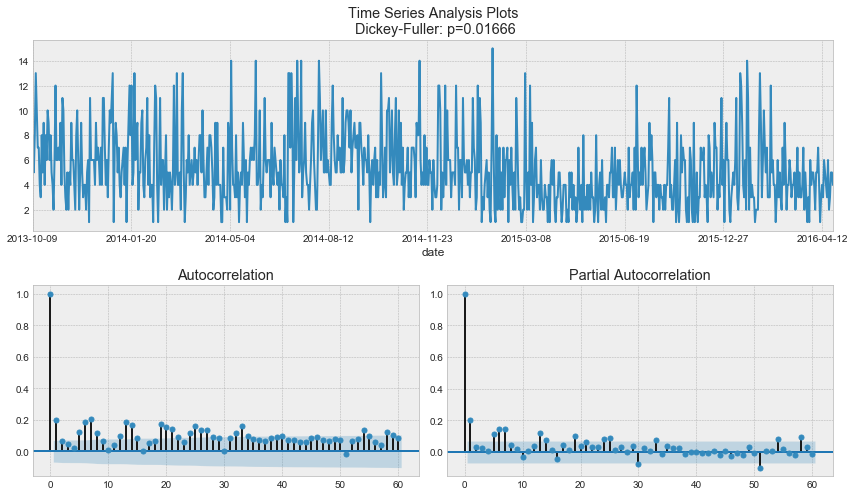

In [139]:
tsplot(df['demand'], lags=60)

Surprisingly, the initial series is stationary; the Dickey-Fuller test rejected the null hypothesis that a unit root is present. We can actually see this on the chart itself - we don't have a visible trend; therefore, the average is constant and the variation is practically stable. The only thing left is seasonality, which we have to deal with before modeling. To do this, we will use the "seasonal difference", which means a simple subtraction of the series from itself with a delay equal to the seasonal period.

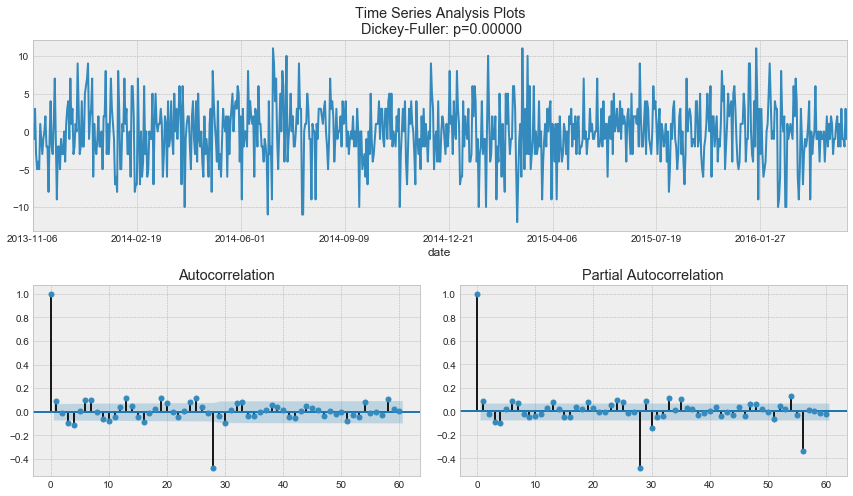

In [140]:
df_diff = df['demand'] - df['demand'].shift(28)
tsplot(df_diff[28:], lags=60)

It is now much better with the visible seasonality gone.

## 4.9 ARIMA Family

I will explain this model by building letter by letter. $ SARIMA (p, d, q) (P, D, Q, s) $, Seasonal moving average of automatic regression (Seasonal Autoregression Moving Average model):


- $ AR (p) $ - automatic regression model, that is, regression of the time series itself. The basic assumption is that the values ​​in the current series depend on their previous values ​​with some delay (or several delays). The maximum delay in the model is referred to as $ p $. To determine the initial $ p $, it is necessary to examine the PACF chart and find the largest significant delay which most other delays become insignificant.


- $ MA (q) $ - moving average model. Without going into too much detail, it models the time series error, again with the assumption that the current error depends on the previous one with some delay, known as $ q $. The initial value can be found on the ACF chart with the same logic as before.


Let's combine our first 4 letters:

$ AR (p) + MA (q) = ARMA (p, q) $


What we have here is the autoregressive moving average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.


- $ I (d) $ - order of integration. This is simply the number of non-seasonal differences needed to make the series stationary. In our case, it's only 1 because we use the first differences.

Adding this letter to the four gives us the $ ARIMA $ model, which can manipulate non-stationary data with the help of non-seasonal differences. Great, one more letter ahead!


- $ S (s) $ - is responsible for seasonality and equal to the length of the series period size

With that, we have three parameters: $ (P, D, Q) $

- $ P $ - automatic regression order for the seasonal component of the model, which can be derived from the PACF. But you need to look at the number of significant delays, which are multiples of the length of the series period. For example, if the period is equal to 28 days and we see that arrears of 28 and 56 are significant in the PACF, this means that the initial $ P $ must be 2.


- $ Q $ - similar logic using the ACF graph.


- $ D $ - seasonal integration order. This can be equal to 1 or 0, depending on whether seasonal differences have been applied or not.

Now that we know how to define the initial parameters, let's take a look at the final graph again and define the parameters:

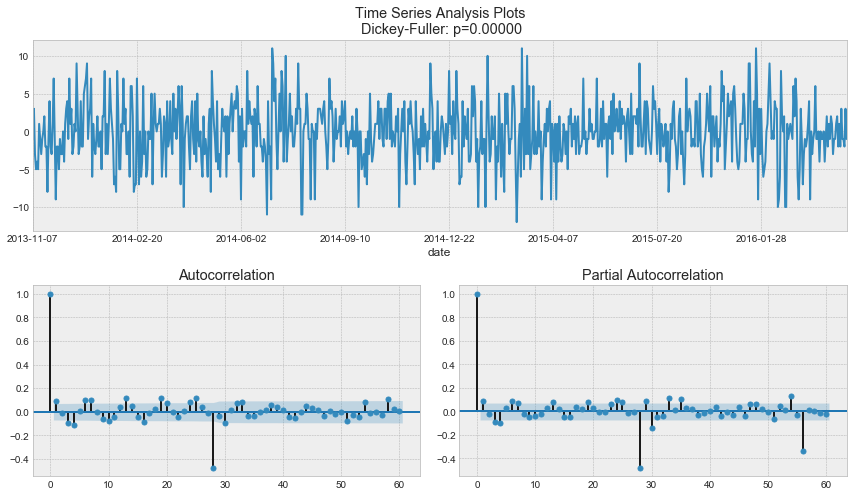

In [141]:
tsplot(df_diff[28+1:], lags=60)

- $ p $ is probably 4, as it is the most significant delay in PACF
- $ d $ is equal to 1 because we had the first differences
- $ q $ should be around 4, just like in ACF
- $ P $ can be 2, as delays 28 and 56 are somewhat significant in the PACF
- $ D $ again equals 1 because we perform seasonal differentiation
- $ Q $ is probably 1. The 28th delay in the ACF is significant, while the 56th is not.

We will test several models and see which one is the best.

In [142]:
# setting initial values and some bounds for them
ps = range(2, 3)
d=1 
qs = range(2, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 28 # season length is still 28

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [143]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [144]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 4min 11s, sys: 32.9 s, total: 4min 44s
Wall time: 1min 14s


In [145]:
result_table.head()

,parameters,aic
0,"(2, 2, 0, 1)",3929.514502
1,"(2, 2, 1, 1)",3931.068836
2,"(2, 2, 1, 0)",4155.265747
3,"(2, 2, 0, 0)",4353.972802


In [146]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                     order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                  812
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 28)   Log Likelihood               -1958.757
Date:                            Tue, 09 Jun 2020   AIC                           3929.515
Time:                                    16:28:31   BIC                           3957.493
Sample:                                         0   HQIC                          3940.274
                                            - 812                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8609      0.043    -19.930      0.000      -0.946      -0.776
ar.L2          0.0754      0.040   

We will inspect the residues of the model.

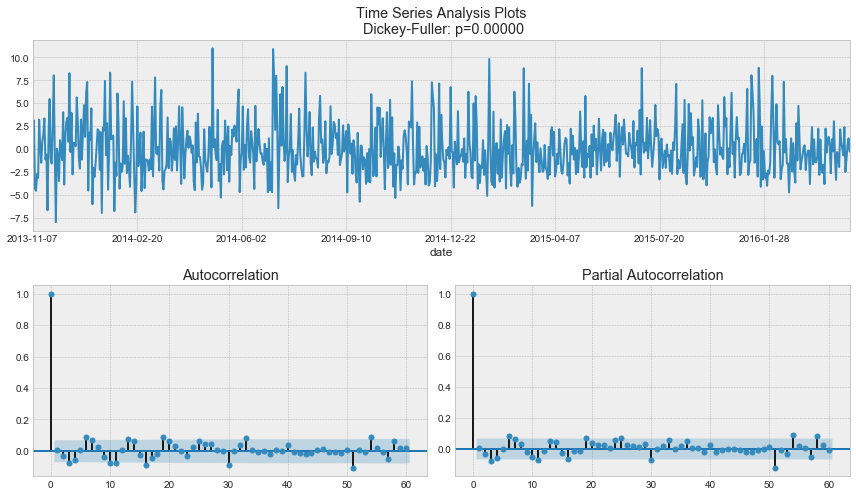

In [147]:
tsplot(best_model.resid[28+1:], lags=60)

It is clear that the residues are stationary and there is no apparent autocorrelation. We will make predictions using our model.

In [148]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    dfCopy = series.copy()
    
    dfCopy['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    dfCopy['arima_model'][:s+d] = np.NaN    
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = dfCopy.shape[0], end = dfCopy.shape[0]+n_steps)
    forecast = dfCopy['arima_model'].append(forecast)

    # calculate error, again having shifted on s+d steps from the beginning
    error = rmse(dfCopy['demand'][s+d:], dfCopy['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("RMSE: {0:.2f}".format(error))
    #plt.plot(forecast, color='r', label="model")
    #plt.axvspan(dfCopy.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(dfCopy['demand'], label="actual")
    plt.legend()
    plt.grid(True);

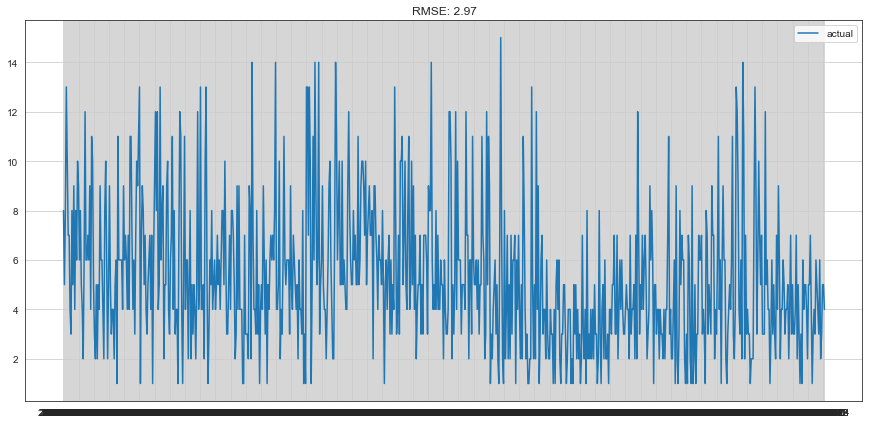

In [149]:
plotSARIMA(df, best_model, 28)

In the end, we got very good forecasts. Our model was off 2.96 (RMSE) on average, which is very, very good. However, the overall costs of data preparation, series preparation and parameter selection may not be worth that precision.
# Part 5. Linear models in time series

These models analyzed so far require a lot of time for data preparation (as in SARIMA) or require frequent training on new data (again, SARIMA) or are difficult to adjust (good example - SARIMA). Therefore, it is often much easier to select some features from the existing time series and create a simple linear regression model or, for example, a random forest.

This approach is not supported by theory and breaks several assumptions (for example, the Gauss-Markov theorem, especially for uncorrelated errors), but it is very useful in practice and is often used in competitions.
# 5.1 Feature Extraction

What features can we extract from this dataset?

    Lags of time series
    Window statistics:
        Max / min value of series in a window
        Average / median value in a window
        Window variance
        etc.
    Date and time features:
        Special events
        Day of the week, month, year, ...
        Holidays
        etc.
    Target encoding
    Forecasts from other models (note that we may lose forecast performance this way)

Let's look at some of the methods and see what we can extract from the data in this competition time series
# 5.2 Time series lags

Changing the nn series backwards, we obtain a feature in which the current value of the time series is aligned with its value at time t − nt − n. If we make a 1 lag change and train a model with this new feature, the model will be able to predict a step forward and observe the current state of the series. Increasing the lag (say), say, up to 28, will allow the model to make predictions 28 steps ahead; however, it will use the data observed in the 28 steps back. If something fundamentally changes the series during that unobserved period, the model will not capture those changes and return predictions with a big error. Therefore, when selecting the initial delay, a balance must be found between the optimal forecast quality and the forecast duration.

In [150]:
# Create a copy of the original dataset
new_df = df.copy ()

# Viewing the dataset
new_df.head ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2013-10-09,8,2,0,8,2,30,4,1,3.980469
2013-10-10,5,2,0,8,2,30,4,0,3.980469
2013-10-11,8,2,0,8,2,30,4,1,3.980469
2013-10-12,13,2,0,8,2,30,4,1,3.980469
2013-10-13,10,2,0,8,2,30,4,0,3.980469


In [151]:
# Adding features considering the demand delay of 7 to 28 days
for i in range (7, 29):
     new_df ["lag _ {}". format (i)] = new_df ['demand']. shift (i)

In [152]:
# Viewing the dataset result
new_df.tail ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag _ 7,lag _ 8,lag _ 9,lag _ 10,lag _ 11,lag _ 12,lag _ 13,lag _ 14,lag _ 15,lag _ 16,lag _ 17,lag _ 18,lag _ 19,lag _ 20,lag _ 21,lag _ 22,lag _ 23,lag _ 24,lag _ 25,lag _ 26,lag _ 27,lag _ 28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,2,0,8,2,30,4,0,3.980469,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,3.0
2016-04-21,3,2,0,8,2,30,4,0,3.980469,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0
2016-04-22,5,2,0,8,2,30,4,0,3.980469,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0
2016-04-23,5,2,0,8,2,30,4,0,3.980469,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0
2016-04-24,4,2,0,8,2,30,4,0,3.980469,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0


Great, we generated a data set here. Why don't we train a model now?

In [153]:
# for time series cross-validation
tscv = TimeSeriesSplit (n_splits = 5)

In [154]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [155]:
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [156]:
# split com 10% para dados de teste
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [157]:
# machine learning em 2 linhas
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [158]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

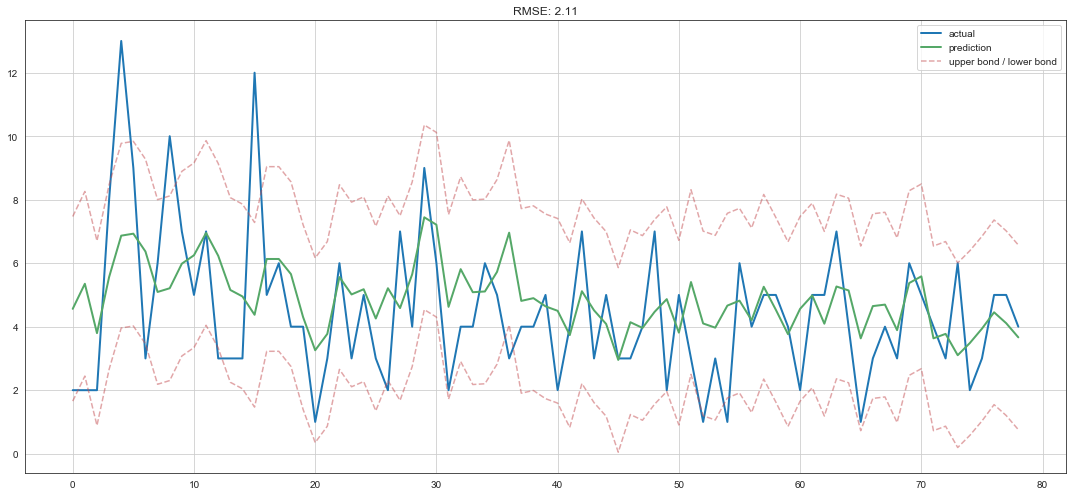

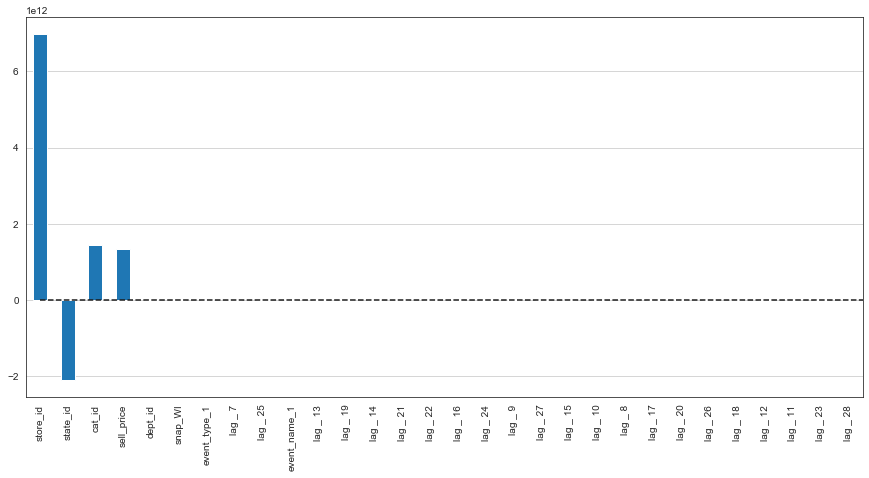

In [159]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us distant forecasts of SARIMA in terms of quality. As there are many unnecessary features, we will do the Feature Selection shortly. For now, let's continue engineering!

We will add some date features. To do this, we need to transform the date to datetime format.

In [160]:
new_df.index = pd.to_datetime(new_df.index)
new_df["day"] = new_df.index.day
new_df["weekday"] = new_df.index.weekday
new_df['is_weekend'] = new_df.weekday.isin([5,6])*1
new_df.tail()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag _ 7,lag _ 8,lag _ 9,lag _ 10,lag _ 11,lag _ 12,lag _ 13,lag _ 14,lag _ 15,lag _ 16,lag _ 17,lag _ 18,lag _ 19,lag _ 20,lag _ 21,lag _ 22,lag _ 23,lag _ 24,lag _ 25,lag _ 26,lag _ 27,lag _ 28,day,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-20,2,2,0,8,2,30,4,0,3.980469,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,3.0,20,2,0
2016-04-21,3,2,0,8,2,30,4,0,3.980469,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,4.0,21,3,0
2016-04-22,5,2,0,8,2,30,4,0,3.980469,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,7.0,22,4,0
2016-04-23,5,2,0,8,2,30,4,0,3.980469,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,2.0,23,5,1
2016-04-24,4,2,0,8,2,30,4,0,3.980469,4.0,5.0,6.0,3.0,4.0,3.0,1.0,4.0,7.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,6.0,1.0,3.0,1.0,3.0,5.0,24,6,1


We can visualize the result:

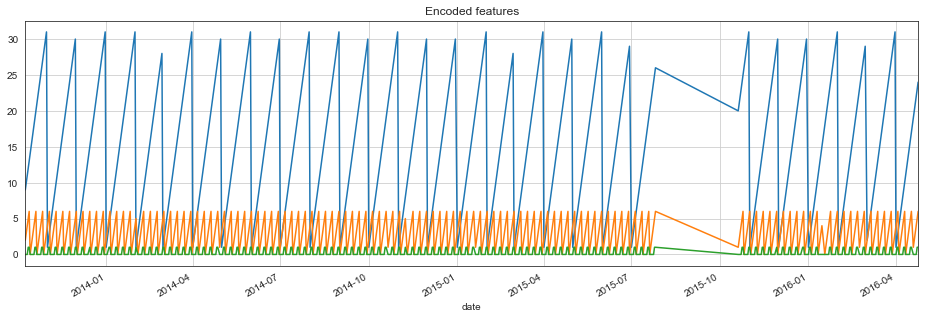

In [161]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
new_df['day'].plot()
new_df['weekday'].plot()
new_df['is_weekend'].plot()
plt.grid(True);

As we now have different scales in our features, we need to transform them in the same scale to explore the importance, later, of regularization.

In [162]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

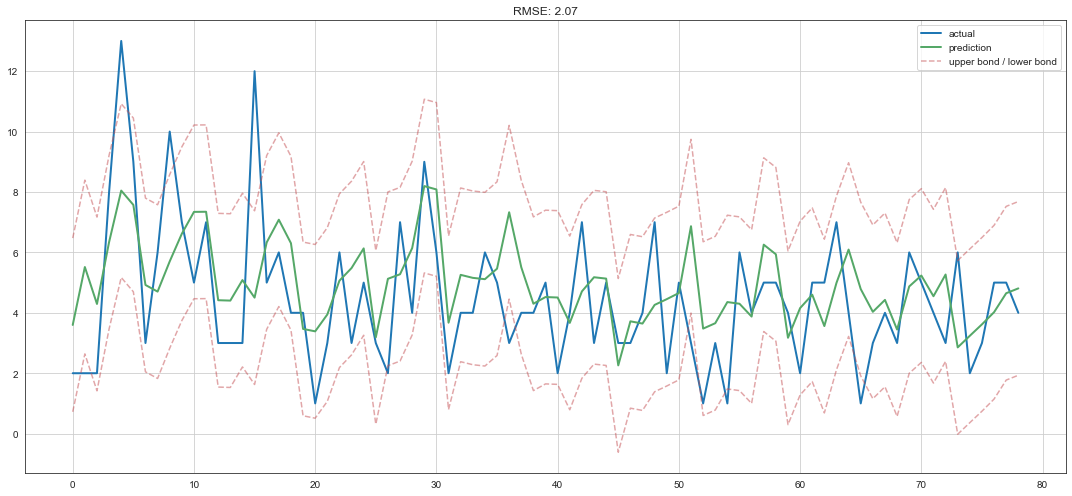

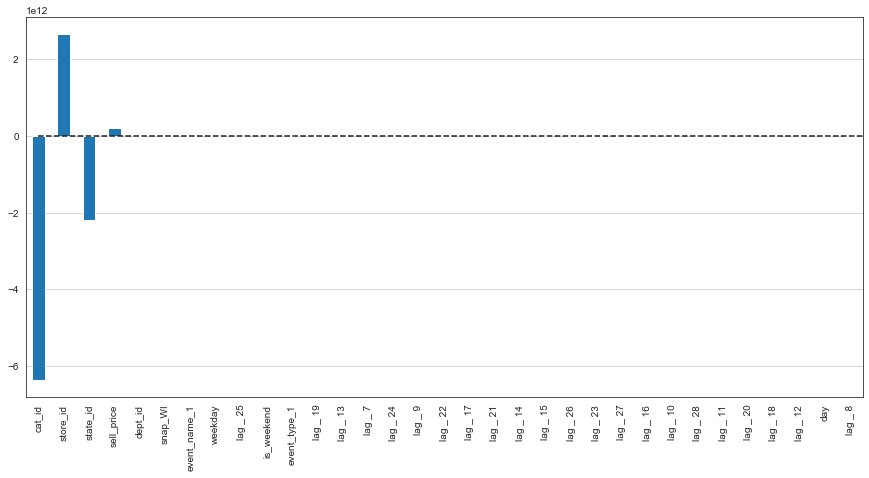

In [163]:
X = new_df.dropna().drop(['demand'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The error remained the same.
# 5.3 Target encoding

I would like to add another variant to encode categorical features: encoding by average value. If it is not desirable to create a data set using many dummy variables that can lead to loss of information and if they cannot be used as real values due to conflicts like "0 hours <23 hours", then it is possible to code a variable with values a little more interpretable. The natural idea is to code with the average value of the target variable. In our example, all days of the week can be coded by the corresponding average number of sales during that day. It is very important to ensure that the average value is calculated only in the training set (or only in the current cross-validation), so that the model knows the future.

In [164]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

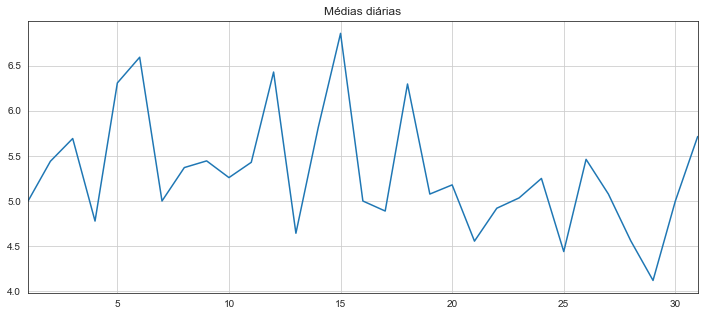

In [165]:
average_day = code_mean(new_df, 'day', "demand")
plt.figure(figsize=(12, 5))
plt.title("Médias diárias")
pd.DataFrame.from_dict(average_day, orient='index')[0].plot()
plt.grid(True);

Finally, we are going to combine all the transformations into a single function.

In [166]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

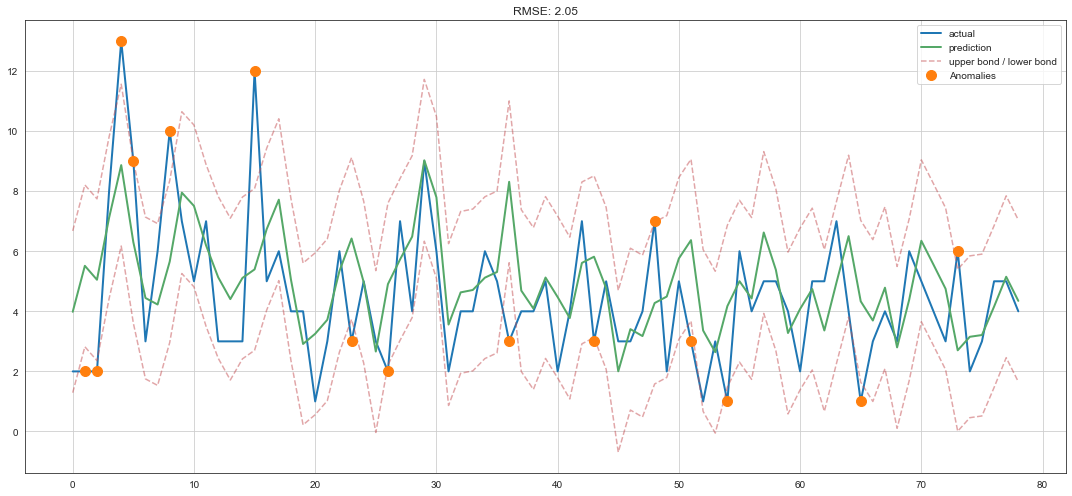

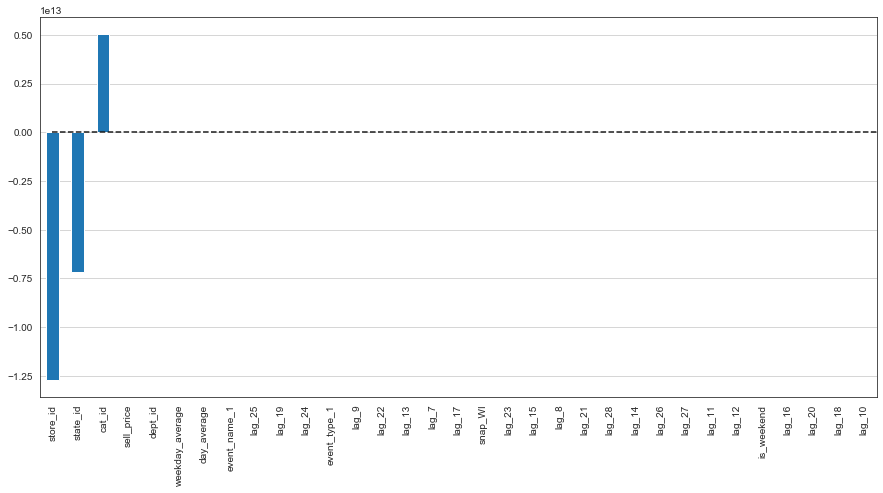

In [167]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

Apparently we see Overfitting! Some features played such a negative role in the training data set that the model decided to concentrate all its strengths on it. As a result, the quality of the forecast has declined. This problem can be solved in several ways; for example, we can calculate the target encoding not for the entire training set, but for some windows. In this way, the encodings of the last observed window will probably better describe the current state of the series. Alternatively, we can simply dispose of it manually, as we are sure that it makes things worse in this case.

In [168]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5.4 Regularization and Feature Selection

As we already know, not all features are equally important - some can lead to overfitting, while others must be removed. In addition to manual inspection, regularization can be applied. Two of the most popular regression models with regularization are the Ridge and Lasso regressions. Both add some more restrictions to our loss function.

In the case of Ridge regression, these restrictions are the sum of the squares of the coefficients multiplied by the smoothing coefficient. The higher the coefficient of a feature, the greater our loss. Therefore, we will try to optimize the model, keeping the coefficients reasonably low.

As a result of this regularization of $ L2 $, we will have a higher bias and less variation, so that the model generalizes better (at least that is what we expect to happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values ​​of the coefficients. As a result, during the optimization process, the coefficients of unimportant features can become zeros, which allows automated selection of resources. This type of regularization is called $ L1 $.

First, let's make sure that we have features to be discarded and that the data has highly correlated features.

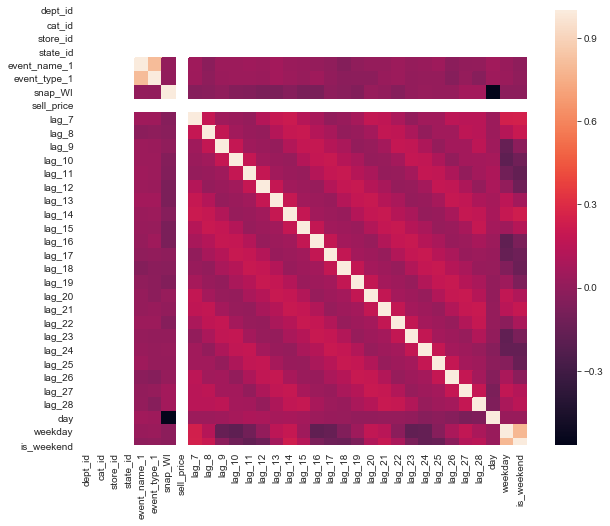

In [169]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

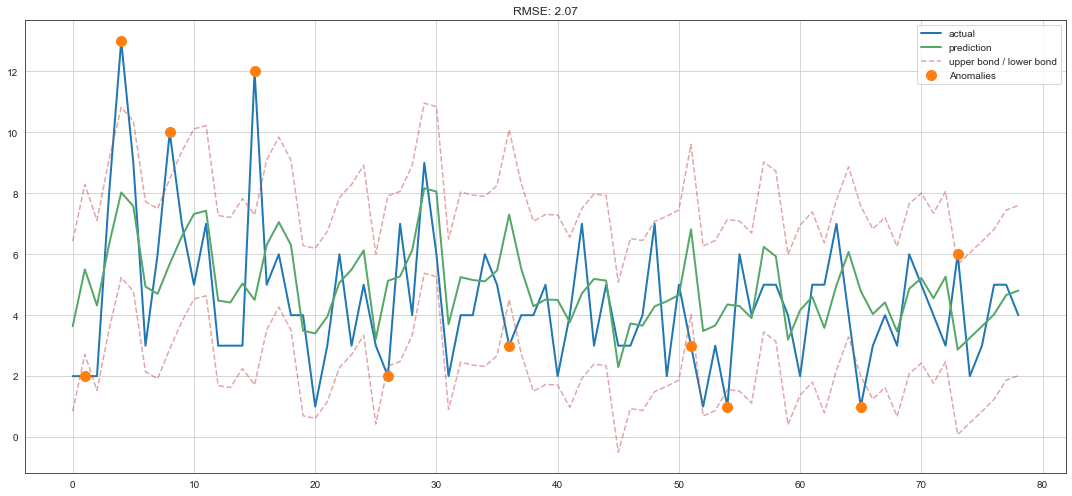

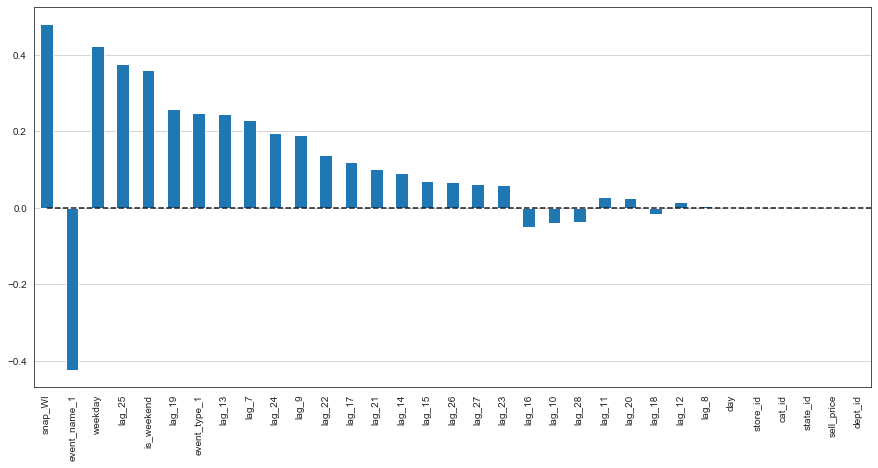

In [170]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see that some coefficients are getting closer to zero (although they never reach it) as their importance in the model decreases.

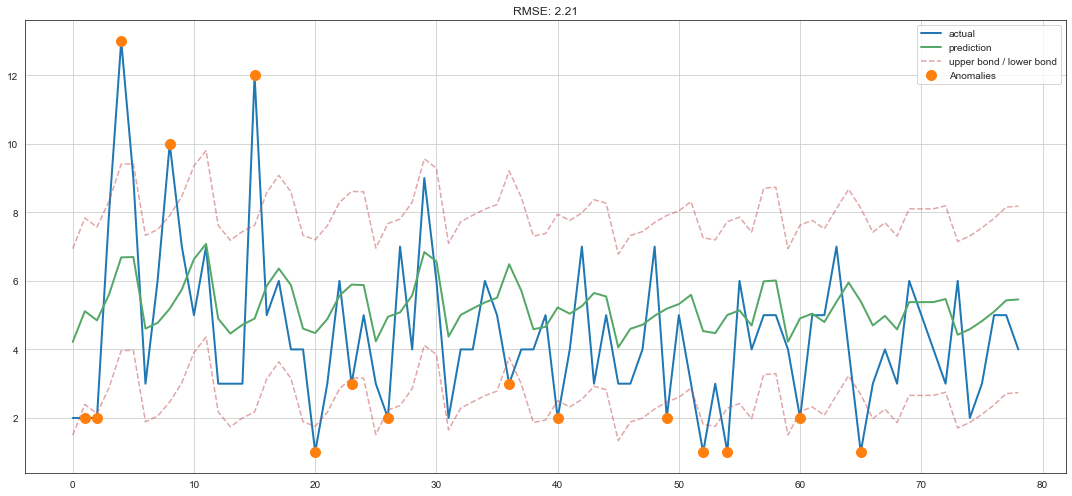

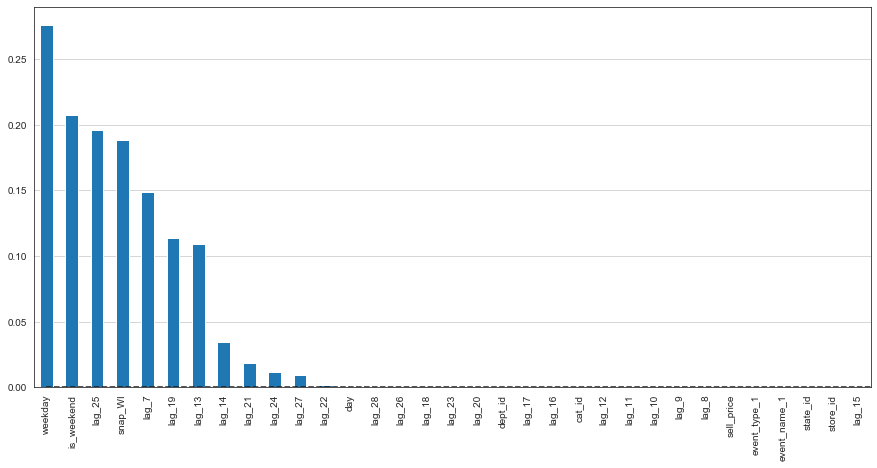

In [171]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(lasso)

The Lasso regression turned out to be more conservative; removed some important lag features which worsened the quality of the forecast.
# Part 6. XGBoost and LightGBM

In [172]:
#import xgboost as xgb
import lightgbm as lgb

In [ ]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

In [ ]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)

In [173]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor()
lgb.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

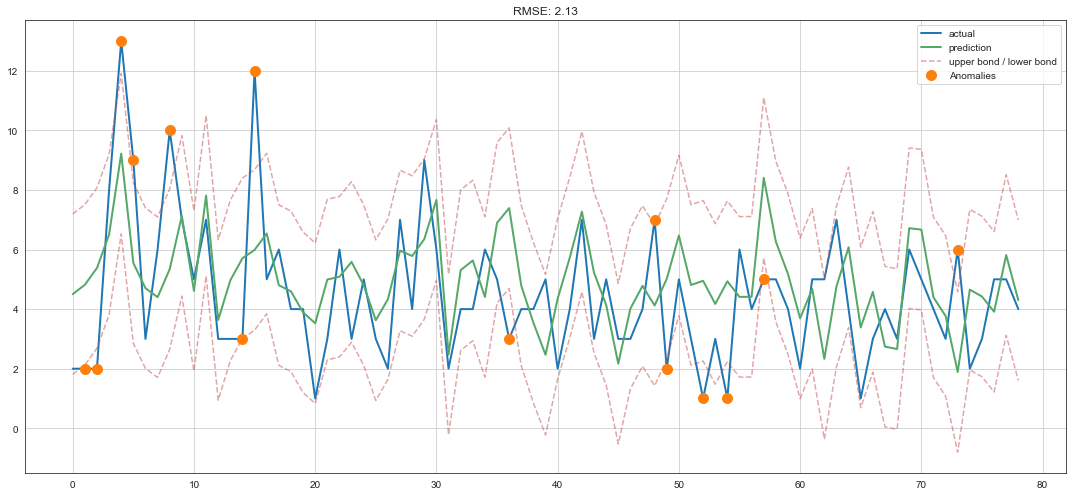

In [174]:
plotModelResults(lgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)